In [1]:
#!TF_ENABLE_DEPRECATION_WARNINGS=1
import os
import pickle
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, Bidirectional, LSTM, Dense,Dropout,BatchNormalization,Activation
from pympler import asizeof
import gc
import sys
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint

2024-01-02 10:55:06.579932: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-02 10:55:06.680996: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-02 10:55:07.648814: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
cpus = tf.config.experimental.list_physical_devices(device_type='CPU')
print(gpus, cpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')] [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [3]:
# 加载 pickle 文件的函数
# 注意需要非常大的内存 实验使用了80G内存
def load_pickle_file(filename):
    with open(filename, 'rb') as file:
        data = pickle.load(file)
    return data

def load_pickle(number):
    # 初始化列表以存储数据
    x_data = []
    y_data = []
    # 遍历当前目录的文件
    for file in os.listdir('VideoFramePickle'):
        if file.endswith(f'_x_{number}.pickle'):
            print(f"filename ---{file}")
            # 直接加载 x 数据
            x = load_pickle_file(os.path.join('VideoFramePickle',file))
            x_data.append(x)
        elif file.endswith(f'_y_{number}.pickle'):
            print(f"filename ---{file}")
            # 直接加载 y 数据
            y = load_pickle_file(os.path.join('VideoFramePickle',file))
            y_data.append(y)
    return x_data,y_data


In [4]:
image_size=50
def process_data_for_model(x,y):
    # 合并所有的 x 和 y 数据
    # 注意需要非常大的内存 实验使用了80G内存
    x_all = np.concatenate(x, axis=0) if x else np.array([])
    # y_all = np.concatenate(y, axis=0) if y else np.array([])
    y_all = np.concatenate(y)
    images_array = np.array(x_all)
    x_all = images_array.reshape(-1, 10, image_size, image_size, 3)
    ## 释放部分内存
    del x
    del y
    del images_array
    print(x_all.shape)
    # print(len(y_all))
    ## 将60G数据分成5份之后，每一份大约12G左右
    print(asizeof.asizeof(x_all)/1024/1024/1024)
    ## 手动触发GC
    gc_count = gc.collect()
    # print(gc_count)
    return x_all,y_all



In [5]:
NAME="CNNBiLSTM"
tensorboard=TensorBoard(log_dir='logs/{}'.format(NAME))

In [6]:
x_data,y_data = load_pickle(1)
x_all,y_all = process_data_for_model(x_data,y_data)

filename ---Anger_x_1.pickle
filename ---Anger_y_1.pickle
filename ---Fear_x_1.pickle
filename ---Fear_y_1.pickle
filename ---Disgust_x_1.pickle
filename ---Disgust_y_1.pickle
filename ---Neutral_x_1.pickle
filename ---Neutral_y_1.pickle
filename ---Happy_x_1.pickle
filename ---Happy_y_1.pickle
filename ---Sad_x_1.pickle
filename ---Sad_y_1.pickle
(138, 10, 50, 50, 3)
0.009639531373977661


In [7]:
print(f"{len(x_data[0])} {len(x_data[1])} {len(x_data[2])} {len(x_data[3])} {len(x_data[4])} {len(x_data[5])}")

7 8 20 18 42 43


In [8]:
print(f"{len(y_data[0])} {len(y_data[1])} {len(y_data[2])} {len(y_data[3])} {len(y_data[4])} {len(y_data[5])}")

7906 8898 9577 9865 9896 10780


In [9]:
print(y_all[0])
print(y_all[7906])
print(y_all[7906+8898])
print(y_all[7906+8898+9577])
print(y_all[7906+8898+9577+9865])
print(y_all[7906+8898+9577+9865+9896])

4
3
2
0
5
1


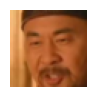

0


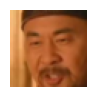

0


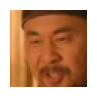

0


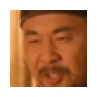

0


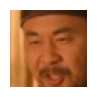

0


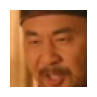

0


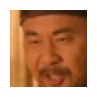

0


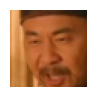

0


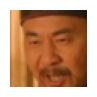

0


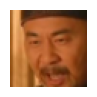

0


In [8]:
import matplotlib.pyplot as plt
for i in range(10):
    plt.figure(figsize=(1., 1.))
    plt.imshow(x_data[0][0][i])
    plt.axis('off')  # 不显示坐标轴
    plt.show()
    print(y_data[0][0])

In [9]:
# 获取 y_all 的类别数，用于 one-hot 编码
num_classes = len(np.unique(y_all))
# 进行 one-hot 编码
y_all = to_categorical(y_all, num_classes)


In [12]:
print(y_all[0])
print(y_all[7906])
print(y_all[7906+8898])
print(y_all[7906+8898+9577])
print(y_all[7906+8898+9577+9865])
print(y_all[7906+8898+9577+9865+9896])

[0. 0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0. 0.]
[0. 0. 1. 0. 0. 0.]
[1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1.]
[0. 1. 0. 0. 0. 0.]


In [10]:
## 归一化
x_all=x_all/255.0

In [11]:
# 获取输入数据的维度信息
time_steps, height, width, channels = x_all.shape[1:]
print(time_steps)
print(height)
print(width)
print(channels)

10
50
50
3


In [2]:
time_steps, height, width, channels = 10,50,50,3
num_classes=6
# 构建 CNN-BiLSTM 模型
model = Sequential()
# 第一层 TimeDistributed 卷积层
model.add(TimeDistributed(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
                          input_shape=(time_steps, height, width, channels)))
# model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
# 添加BN层
model.add(TimeDistributed(BatchNormalization()))
# 添加激活函数
model.add(TimeDistributed(Activation('relu')))

# 第二层 TimeDistributed 卷积层
model.add(TimeDistributed(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')))
# model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
# 添加BN层
model.add(TimeDistributed(BatchNormalization()))
# 添加激活函数
model.add(TimeDistributed(Activation('relu')))

# 第三层 TimeDistributed 卷积层
model.add(TimeDistributed(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')))
# model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
# 添加BN层
model.add(TimeDistributed(BatchNormalization()))
# 添加激活函数
model.add(TimeDistributed(Activation('relu')))

# 对特征图进行扁平化处理，为序列处理层准备
model.add(TimeDistributed(Flatten()))

# 添加双向 LSTM 层来处理时间序列，这里不返回序列，只返回最后一个输出
model.add(Bidirectional(LSTM(units=100, return_sequences=False)))
# , dropout=0.25, recurrent_dropout=0.25

# 添加全连接层
# model.add(Dense(units=128, activation='relu'))
# model.add((Dropout(0.5)))
model.add(Dense(units=64, activation='relu'))
# model.add((Dropout(0.5)))
model.add(Dense(units=32, activation='relu'))

# 添加全连接层输出最终预测，使用 softmax 函数进行多类分类
model.add(Dense(units=num_classes, activation='softmax'))

# 编译模型，使用分类交叉熵作为损失函数，优化器选择 Adam，评价指标使用准确率
LR = 0.0001
opt = tf.keras.optimizers.legacy.Adam(learning_rate=LR)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# 打印模型结构
model.summary()

2024-01-01 11:56:10.132551: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22288 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:18:00.0, compute capability: 8.9


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 10, 50, 50, 32)    896       
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 10, 50, 50, 32)    128       
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 10, 50, 50, 32)    0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 10, 50, 50, 64)    18496     
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, 10, 50, 50, 64)    2

In [13]:
#保存文件，下次直接使用
# 单独保存每个数组到.npy文件
np.save('VideoFramePickle/x_all.npy', x_all)
np.save('VideoFramePickle/y_all.npy', y_all)

In [6]:
#直接加载文件
x_all = np.load('VideoFramePickle/x_all.npy')
y_all = np.load('VideoFramePickle/y_all.npy')

In [7]:
# 现在，可以使用来训练模型
x_train, x_second, y_train, y_second = train_test_split(x_all, y_all, test_size=0.1, random_state=42)

In [8]:
np.save('VideoFramePickle/x_test.npy', x_second)
np.save('VideoFramePickle/y_test.npy', y_second)

In [9]:
np.save('VideoFramePickle/x_train.npy', x_train)
np.save('VideoFramePickle/y_train.npy', y_train)

In [10]:
x_train = np.load('VideoFramePickle/x_train.npy')
y_train = np.load('VideoFramePickle/y_train.npy')

In [8]:
# 配置模型检查点
checkpoint = ModelCheckpoint(
    'CNNBiLSTM_epoch_{epoch:02d}.h5',  # 文件路径，其中{epoch:02d}是格式化字符串，用于在文件名中包含epoch编号
    monitor='val_accuracy',            # 可以是'val_loss', 'val_accuracy', 'loss', 'accuracy'等
    verbose=1,                        # 日志显示模式，0或1
    save_best_only=False,             # 如果设置为True，则只保存在验证集上性能最好的模型
    save_weights_only=False,          # 如果设置为True，则只保存模型的权重，如果为False，则保存整个模型
    mode='auto',                      # 可以是'auto', 'min', 'max'，决定了监控指标是应该最大化还是最小化
    save_freq='epoch'                 # 检查点之间的间隔（每个epoch）
)
history = model.fit(
    x_train, y_train, 
    epochs=50, 
    batch_size=10, 
    # validation_data=(x_val, y_val),
    validation_split=0.3,
    callbacks=[checkpoint],
    verbose=1,
    workers=128,
    shuffle=True
)

Epoch 1/50


2023-12-25 20:57:39.732170: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-12-25 20:57:40.028575: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3188/3188 [==============================] - ETA: 0s - loss: 1.7447 - accuracy: 0.2248
Epoch 1: saving model to CNNBiLSTM_epoch_01.h5


/root/miniconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3188/3188 [==============================] - 209s 64ms/step - loss: 1.7447 - accuracy: 0.2248 - val_loss: 1.5945 - val_accuracy: 0.2832
Epoch 2/50
3187/3188 [============================>.] - ETA: 0s - loss: 1.4459 - accuracy: 0.3865
Epoch 2: saving model to CNNBiLSTM_epoch_02.h5
3188/3188 [==============================] - 195s 61ms/step - loss: 1.4459 - accuracy: 0.3865 - val_loss: 1.3332 - val_accuracy: 0.4543
Epoch 3/50
3187/3188 [============================>.] - ETA: 0s - loss: 1.1763 - accuracy: 0.5267
Epoch 3: saving model to CNNBiLSTM_epoch_03.h5
3188/3188 [==============================] - 195s 61ms/step - loss: 1.1763 - accuracy: 0.5267 - val_loss: 1.1281 - val_accuracy: 0.5520
Epoch 4/50
3187/3188 [============================>.] - ETA: 0s - loss: 0.9759 - accuracy: 0.6243
Epoch 4: saving model to CNNBiLSTM_epoch_04.h5
3188/3188 [==============================] - 189s 59ms/step - loss: 0.9758 - accuracy: 0.6244 - val_loss: 0.9945 - val_accuracy: 0.6132
Epoch 5/50
3187/3188 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2902/3188 [==========================>...] - ETA: 14s - loss: 0.0147 - accuracy: 0.9953

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1798/3188 [===============>..............] - ETA: 1:12 - loss: 0.0078 - accuracy: 0.9975

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



3187/3188 [============================>.] - ETA: 0s - loss: 0.0085 - accuracy: 0.9976
Epoch 30: saving model to CNNBiLSTM_epoch_30.h5
3188/3188 [==============================] - 195s 61ms/step - loss: 0.0085 - accuracy: 0.9976 - val_loss: 0.9671 - val_accuracy: 0.8166
Epoch 31/50
 287/3188 [=>............................] - ETA: 2:27 - loss: 0.0067 - accuracy: 0.9983

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2353/3188 [=====================>........] - ETA: 43s - loss: 0.0104 - accuracy: 0.9969

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



3187/3188 [============================>.] - ETA: 0s - loss: 0.0093 - accuracy: 0.9971
Epoch 34: saving model to CNNBiLSTM_epoch_34.h5
3188/3188 [==============================] - 195s 61ms/step - loss: 0.0093 - accuracy: 0.9971 - val_loss: 0.9780 - val_accuracy: 0.8207
Epoch 35/50
1929/3188 [=================>............] - ETA: 1:05 - loss: 0.0052 - accuracy: 0.9984

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



3187/3188 [============================>.] - ETA: 0s - loss: 0.0076 - accuracy: 0.9972
Epoch 36: saving model to CNNBiLSTM_epoch_36.h5
3188/3188 [==============================] - 194s 61ms/step - loss: 0.0076 - accuracy: 0.9972 - val_loss: 0.9993 - val_accuracy: 0.8196
Epoch 37/50
3187/3188 [============================>.] - ETA: 0s - loss: 0.0062 - accuracy: 0.9978
Epoch 37: saving model to CNNBiLSTM_epoch_37.h5
3188/3188 [==============================] - 197s 62ms/step - loss: 0.0062 - accuracy: 0.9978 - val_loss: 1.0454 - val_accuracy: 0.8213
Epoch 38/50
3187/3188 [============================>.] - ETA: 0s - loss: 0.0054 - accuracy: 0.9982
Epoch 38: saving model to CNNBiLSTM_epoch_38.h5
3188/3188 [==============================] - 196s 62ms/step - loss: 0.0054 - accuracy: 0.9982 - val_loss: 0.9600 - val_accuracy: 0.8317
Epoch 39/50
3187/3188 [============================>.] - ETA: 0s - loss: 0.0062 - accuracy: 0.9979
Epoch 39: saving model to CNNBiLSTM_epoch_39.h5
3188/3188 [=====

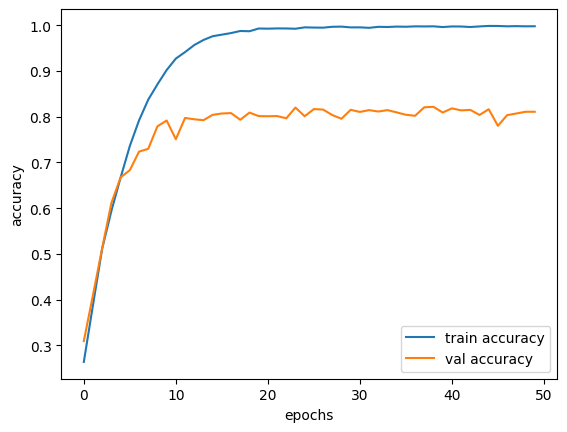

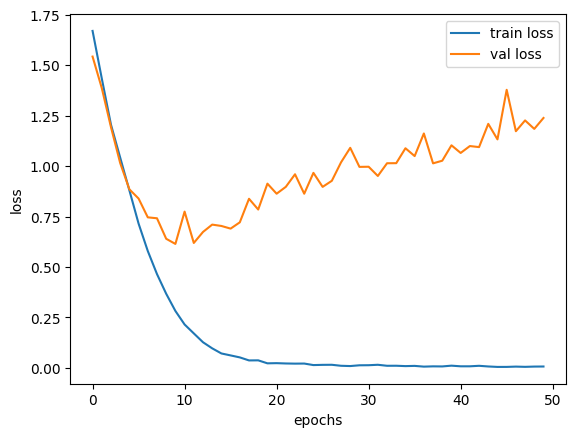

In [9]:
import matplotlib.pyplot as plt
epochs = list(range(50))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, label='train accuracy')
plt.plot(epochs, val_acc, label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, label='train loss')
plt.plot(epochs, val_loss, label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [6]:
model=tf.keras.models.load_model("CNNBiLSTM_epoch_16.h5")
x_test = np.load('VideoFramePickle/x_test.npy')
y_test = np.load('VideoFramePickle/y_test.npy')
loss,acc = model.evaluate(x_test,y_test)
print(f"loss {loss},acc {acc}")

2023-12-25 15:14:58.609064: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22288 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:18:00.0, compute capability: 8.9
2023-12-25 15:15:25.200787: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


  7/356 [..............................] - ETA: 9s - loss: 0.6480 - accuracy: 0.8304

2023-12-25 15:15:25.541631: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


356/356 [==============================] - 11s 28ms/step - loss: 0.7153 - accuracy: 0.8018
loss 0.7153488397598267,acc 0.8017566800117493
